In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os 
from os import path
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            #slope = (y2-y1)/(x2-x1)
            angle = (np.rad2deg(np.arctan2(y1 - y2, x1 - x2)))
            #print('steering angle : ', angle)
            if (angle<-120.0 and angle>-150.0) or (angle>=120.0 and angle<=150.0):
                #print('steering angle : ', angle)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    color=(255, 0, 0)
    draw_lines(line_img, lines,color,3)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(path):
    #reading in an image
    #print('Path : ',path)
    if type(path) == str :
        image = mpimg.imread(path)
    else :
        image = path
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    #plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

    #Converting image to grayscale
    grayimg = grayscale(image)
    #plt.imshow(grayimg, cmap='gray')

    #Smoothing the image with gaussian noise using correlation
    kernel_size=7
    blurgrayimg = gaussian_blur(grayimg, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 100
    cnedges=canny(blurgrayimg,low_threshold,high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[[460,320],[500,320],[900,550],[100,550]]],dtype=np.int32)
    roi = region_of_interest(cnedges,vertices)
    #plt.imshow(roi, cmap='gray')

    # Definmpimg.imshow(masked_edges)e the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap =  20   # maximum gap in pixels between connectable line segments

    hgimg = hough_lines(roi, rho, theta, threshold, min_line_length, max_line_gap)
    #plt.imshow(hgimg, cmap='gray')


    #coledges = np.dstack((cnedges,cnedges,cnedges))
    lineimage = weighted_img(hgimg, image, α=0.8, β=1, λ=0.)
    #plt.figure()
    #plt.imshow(lineimage)
    return lineimage
    
def processBatchImage(dirPath):
    files = [x for x in os.listdir(dirPath) if path.isfile(dirPath+os.sep+x)]
    for f in files :
        plt.figure()
        plt.imshow(process_image(dirPath+os.sep+f))
    
    return 


def process_video(output,input) :
    white_output = output
    clip1 = VideoFileClip(input)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

    return """
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(white_output)

#'''Process the test images'''
#processBatchImage("test_images/")

#'''Process The White Right video'''
#HTML(process_video('white.mp4',"solidWhiteRight.mp4"))

#'''Process The Yellow Left video'''
#HTML(process_video('yellow.mp4',"solidYellowLeft.mp4"))

#'''Process The Challenge video'''
#HTML(process_video('extra.mp4',"challenge.mp4"))


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  1%|          | 2/222 [00:00<00:11, 18.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  5%|▍         | 10/222 [00:00<00:08, 24.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  9%|▊         | 19/222 [00:00<00:06, 29.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 12%|█▏        | 27/222 [00:00<00:06, 31.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 16%|█▌        | 36/222 [00:01<00:05, 34.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 18%|█▊        | 40/222 [00:01<00:05, 35.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 20%|█▉        | 44/222 [00:01<00:07, 24.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 23%|██▎       | 50/222 [00:01<00:09, 18.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 24%|██▍       | 53/222 [00:02<00:10, 16.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 26%|██▌       | 57/222 [00:02<00:11, 14.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 27%|██▋       | 61/222 [00:02<00:11, 14.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 29%|██▉       | 65/222 [00:02<00:10, 14.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 31%|███       | 69/222 [00:03<00:10, 15.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 32%|███▏      | 71/222 [00:03<00:09, 15.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 34%|███▍      | 75/222 [00:03<00:10, 14.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 36%|███▌      | 79/222 [00:03<00:09, 15.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 37%|███▋      | 83/222 [00:04<00:09, 14.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 39%|███▉      | 87/222 [00:04<00:08, 15.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 41%|████      | 91/222 [00:04<00:08, 15.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 43%|████▎     | 95/222 [00:04<00:08, 15.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 45%|████▍     | 99/222 [00:05<00:07, 15.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 46%|████▋     | 103/222 [00:05<00:07, 15.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 48%|████▊     | 107/222 [00:05<00:07, 15.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 50%|█████     | 111/222 [00:05<00:07, 15.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 52%|█████▏    | 115/222 [00:06<00:06, 15.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████▎    | 119/222 [00:06<00:06, 14.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 55%|█████▌    | 123/222 [00:06<00:06, 15.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 57%|█████▋    | 127/222 [00:06<00:06, 15.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 58%|█████▊    | 129/222 [00:07<00:06, 15.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 60%|█████▉    | 133/222 [00:07<00:06, 14.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 61%|██████    | 135/222 [00:07<00:06, 14.04it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 63%|██████▎   | 139/222 [00:07<00:06, 13.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 64%|██████▍   | 143/222 [00:08<00:05, 13.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 65%|██████▌   | 145/222 [00:08<00:05, 13.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 66%|██████▌   | 147/222 [00:08<00:05, 13.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 68%|██████▊   | 151/222 [00:08<00:05, 13.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 70%|██████▉   | 155/222 [00:09<00:04, 14.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 71%|███████   | 157/222 [00:09<00:04, 14.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 73%|███████▎  | 161/222 [00:09<00:04, 12.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 73%|███████▎  | 163/222 [00:09<00:04, 12.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 74%|███████▍  | 165/222 [00:09<00:04, 11.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 75%|███████▌  | 167/222 [00:10<00:05, 10.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 77%|███████▋  | 171/222 [00:10<00:05,  9.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 78%|███████▊  | 173/222 [00:10<00:05,  9.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 79%|███████▉  | 175/222 [00:11<00:05,  9.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 80%|███████▉  | 177/222 [00:11<00:04,  9.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 81%|████████  | 180/222 [00:11<00:04,  9.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 82%|████████▏ | 182/222 [00:11<00:04,  8.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 84%|████████▍ | 186/222 [00:12<00:03,  9.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 85%|████████▍ | 188/222 [00:12<00:03, 10.03it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 86%|████████▌ | 190/222 [00:12<00:03,  9.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 87%|████████▋ | 193/222 [00:12<00:03,  8.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 88%|████████▊ | 195/222 [00:13<00:03,  8.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 89%|████████▉ | 198/222 [00:13<00:02,  9.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 91%|█████████ | 202/222 [00:13<00:01, 11.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 93%|█████████▎| 206/222 [00:14<00:01, 12.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 95%|█████████▍| 210/222 [00:14<00:00, 13.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 96%|█████████▋| 214/222 [00:14<00:00, 14.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 98%|█████████▊| 218/222 [00:14<00:00, 14.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


100%|█████████▉| 221/222 [00:15<00:00, 14.67it/s]


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1.82 s, sys: 104 ms, total: 1.92 s
Wall time: 16.6 s


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


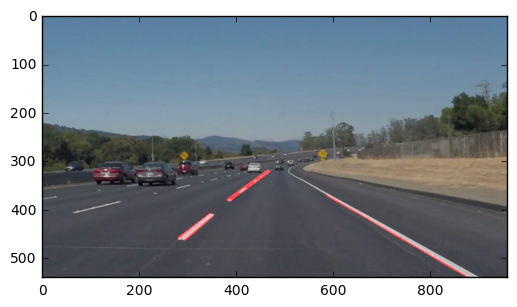

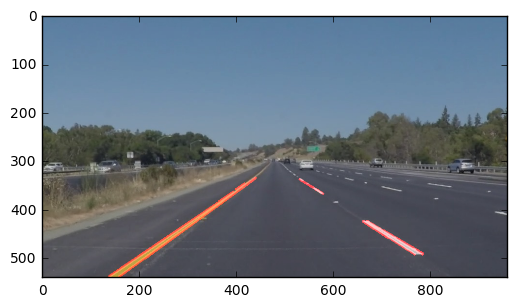

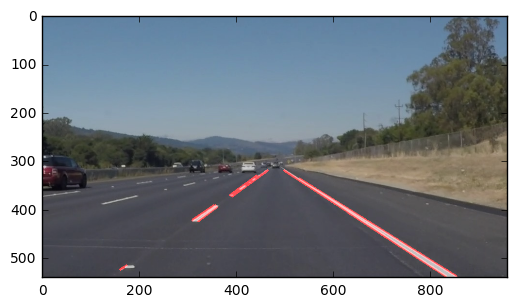

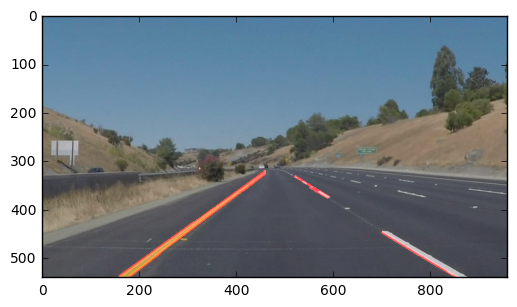

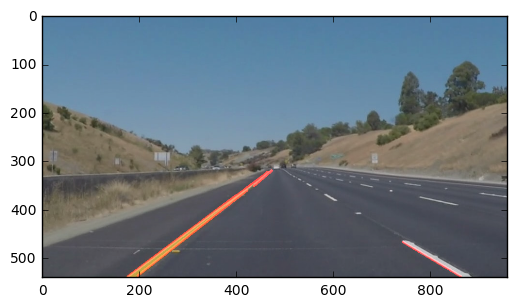

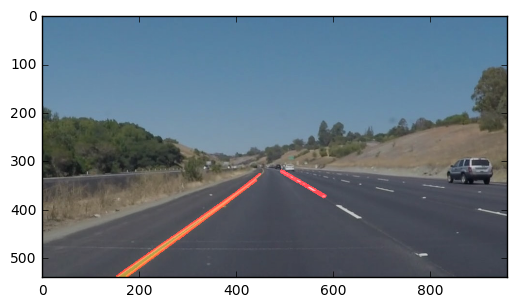

In [11]:
#'''Process the test images'''
processBatchImage("test_images/")

In [12]:

#'''Process The White Right video'''
HTML(process_video('white.mp4',"solidWhiteRight.mp4"))

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  1%|          | 2/222 [00:00<00:13, 16.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  4%|▍         | 9/222 [00:00<00:10, 21.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  6%|▌         | 13/222 [00:00<00:08, 23.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  8%|▊         | 17/222 [00:00<00:08, 25.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  9%|▉         | 20/222 [00:00<00:07, 26.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 11%|█         | 24/222 [00:00<00:07, 27.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 12%|█▏        | 27/222 [00:00<00:07, 25.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 14%|█▎        | 30/222 [00:01<00:07, 24.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 15%|█▍        | 33/222 [00:01<00:07, 25.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 16%|█▌        | 36/222 [00:01<00:08, 22.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 18%|█▊        | 39/222 [00:01<00:08, 21.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 19%|█▉        | 42/222 [00:01<00:08, 21.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 20%|██        | 45/222 [00:02<00:11, 15.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 22%|██▏       | 49/222 [00:02<00:13, 12.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 24%|██▍       | 53/222 [00:02<00:12, 13.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 25%|██▍       | 55/222 [00:02<00:12, 13.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 27%|██▋       | 59/222 [00:03<00:13, 12.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 27%|██▋       | 61/222 [00:03<00:13, 11.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 29%|██▉       | 65/222 [00:03<00:12, 12.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 31%|███       | 69/222 [00:03<00:11, 13.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 33%|███▎      | 73/222 [00:04<00:11, 13.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 35%|███▍      | 77/222 [00:04<00:10, 13.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 36%|███▋      | 81/222 [00:04<00:09, 14.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 38%|███▊      | 85/222 [00:05<00:09, 14.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 40%|████      | 89/222 [00:05<00:09, 14.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 41%|████      | 91/222 [00:05<00:09, 13.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 43%|████▎     | 95/222 [00:05<00:09, 13.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 44%|████▎     | 97/222 [00:06<00:09, 13.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 45%|████▌     | 101/222 [00:06<00:09, 13.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 47%|████▋     | 105/222 [00:06<00:08, 13.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 49%|████▉     | 109/222 [00:06<00:07, 14.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 51%|█████     | 113/222 [00:07<00:07, 14.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 52%|█████▏    | 115/222 [00:07<00:08, 13.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████▎    | 119/222 [00:07<00:08, 11.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 55%|█████▍    | 121/222 [00:07<00:08, 11.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 56%|█████▋    | 125/222 [00:08<00:08, 12.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 58%|█████▊    | 129/222 [00:08<00:07, 12.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 59%|█████▉    | 131/222 [00:08<00:07, 11.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 60%|█████▉    | 133/222 [00:08<00:07, 11.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 62%|██████▏   | 137/222 [00:09<00:07, 11.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 63%|██████▎   | 139/222 [00:09<00:07, 11.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 64%|██████▎   | 141/222 [00:09<00:06, 12.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 65%|██████▌   | 145/222 [00:10<00:07, 10.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 66%|██████▌   | 147/222 [00:10<00:06, 10.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 68%|██████▊   | 151/222 [00:10<00:06, 11.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 70%|██████▉   | 155/222 [00:10<00:05, 12.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 71%|███████   | 157/222 [00:11<00:05, 11.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 72%|███████▏  | 159/222 [00:11<00:05, 11.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 73%|███████▎  | 161/222 [00:11<00:06, 10.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 74%|███████▍  | 165/222 [00:12<00:06,  8.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 75%|███████▍  | 166/222 [00:12<00:06,  8.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 76%|███████▌  | 168/222 [00:12<00:06,  7.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 77%|███████▋  | 170/222 [00:12<00:06,  7.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 77%|███████▋  | 172/222 [00:13<00:06,  7.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 78%|███████▊  | 174/222 [00:13<00:06,  7.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 79%|███████▉  | 176/222 [00:13<00:07,  6.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 80%|████████  | 178/222 [00:14<00:06,  6.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 81%|████████  | 180/222 [00:14<00:05,  7.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 82%|████████▏ | 183/222 [00:14<00:04,  7.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 84%|████████▍ | 186/222 [00:14<00:04,  8.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 85%|████████▍ | 188/222 [00:15<00:04,  7.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 86%|████████▋ | 192/222 [00:15<00:03,  8.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 87%|████████▋ | 193/222 [00:15<00:03,  8.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 89%|████████▊ | 197/222 [00:16<00:02,  9.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 89%|████████▉ | 198/222 [00:16<00:02,  8.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 91%|█████████ | 201/222 [00:16<00:02,  9.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 92%|█████████▏| 205/222 [00:16<00:01, 10.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 94%|█████████▍| 209/222 [00:17<00:01, 12.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 96%|█████████▌| 213/222 [00:17<00:00, 11.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 97%|█████████▋| 215/222 [00:17<00:00, 11.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 99%|█████████▊| 219/222 [00:18<00:00, 10.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


100%|█████████▉| 221/222 [00:18<00:00, 11.05it/s]


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1.99 s, sys: 132 ms, total: 2.12 s
Wall time: 19.9 s


In [13]:
#'''Process The Yellow Left video'''
HTML(process_video('yellow.mp4',"solidYellowLeft.mp4"))


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 2/682 [00:00<00:44, 15.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  1%|          | 8/682 [00:00<00:33, 19.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  2%|▏         | 17/682 [00:00<00:25, 25.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  4%|▎         | 25/682 [00:00<00:21, 30.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  4%|▍         | 29/682 [00:00<00:21, 29.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  5%|▍         | 34/682 [00:01<00:20, 32.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  6%|▌         | 38/682 [00:01<00:20, 31.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  6%|▌         | 42/682 [00:01<00:20, 31.75it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  7%|▋         | 46/682 [00:01<00:30, 20.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  7%|▋         | 49/682 [00:01<00:35, 18.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  8%|▊         | 52/682 [00:02<00:38, 16.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  8%|▊         | 56/682 [00:02<00:41, 15.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  9%|▉         | 60/682 [00:02<00:46, 13.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  9%|▉         | 62/682 [00:02<00:47, 12.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 10%|▉         | 66/682 [00:03<00:46, 13.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 10%|█         | 70/682 [00:03<00:44, 13.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 11%|█         | 74/682 [00:03<00:43, 14.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 11%|█▏        | 78/682 [00:04<00:42, 14.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 12%|█▏        | 82/682 [00:04<00:40, 14.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 13%|█▎        | 86/682 [00:04<00:40, 14.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 13%|█▎        | 90/682 [00:04<00:41, 14.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 13%|█▎        | 92/682 [00:05<00:43, 13.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 14%|█▍        | 94/682 [00:05<00:50, 11.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 14%|█▍        | 98/682 [00:05<00:51, 11.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 15%|█▍        | 100/682 [00:05<00:49, 11.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 15%|█▌        | 104/682 [00:06<00:48, 11.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 16%|█▌        | 108/682 [00:06<00:43, 13.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 16%|█▌        | 110/682 [00:06<00:48, 11.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 17%|█▋        | 114/682 [00:06<00:50, 11.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 17%|█▋        | 116/682 [00:07<00:52, 10.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 17%|█▋        | 118/682 [00:07<00:54, 10.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 18%|█▊        | 120/682 [00:07<01:00,  9.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 18%|█▊        | 122/682 [00:07<01:09,  8.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 18%|█▊        | 126/682 [00:08<00:54, 10.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 19%|█▉        | 130/682 [00:08<00:45, 12.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 19%|█▉        | 132/682 [00:08<00:45, 11.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 20%|█▉        | 136/682 [00:09<00:45, 12.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 20%|██        | 138/682 [00:09<00:43, 12.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 21%|██        | 140/682 [00:09<00:43, 12.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 21%|██        | 144/682 [00:09<00:47, 11.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 22%|██▏       | 148/682 [00:09<00:41, 12.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 22%|██▏       | 152/682 [00:10<00:39, 13.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 23%|██▎       | 156/682 [00:10<00:38, 13.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 23%|██▎       | 160/682 [00:10<00:37, 13.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 24%|██▍       | 162/682 [00:11<00:39, 13.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 24%|██▍       | 166/682 [00:11<00:43, 11.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 25%|██▍       | 168/682 [00:11<00:42, 12.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 25%|██▌       | 172/682 [00:11<00:40, 12.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 26%|██▌       | 174/682 [00:12<00:39, 12.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 26%|██▌       | 178/682 [00:12<00:39, 12.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 27%|██▋       | 182/682 [00:12<00:37, 13.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 27%|██▋       | 186/682 [00:12<00:40, 12.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 28%|██▊       | 190/682 [00:13<00:37, 13.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 28%|██▊       | 192/682 [00:13<00:36, 13.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 28%|██▊       | 194/682 [00:13<00:37, 12.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 29%|██▉       | 198/682 [00:13<00:38, 12.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 30%|██▉       | 202/682 [00:14<00:35, 13.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 30%|███       | 206/682 [00:14<00:34, 13.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 31%|███       | 210/682 [00:14<00:33, 14.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 31%|███▏      | 214/682 [00:15<00:33, 14.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 32%|███▏      | 218/682 [00:15<00:32, 14.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 33%|███▎      | 222/682 [00:15<00:32, 14.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 33%|███▎      | 226/682 [00:15<00:33, 13.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 33%|███▎      | 228/682 [00:16<00:33, 13.74it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 34%|███▍      | 232/682 [00:16<00:33, 13.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 35%|███▍      | 236/682 [00:16<00:32, 13.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 35%|███▌      | 240/682 [00:16<00:32, 13.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 35%|███▌      | 242/682 [00:17<00:35, 12.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 36%|███▌      | 246/682 [00:17<00:35, 12.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 37%|███▋      | 250/682 [00:17<00:36, 11.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 37%|███▋      | 252/682 [00:17<00:37, 11.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 38%|███▊      | 256/682 [00:18<00:35, 12.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 38%|███▊      | 258/682 [00:18<00:35, 11.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 38%|███▊      | 262/682 [00:18<00:33, 12.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 39%|███▊      | 264/682 [00:18<00:33, 12.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 39%|███▉      | 268/682 [00:19<00:32, 12.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 40%|███▉      | 272/682 [00:19<00:30, 13.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 40%|████      | 276/682 [00:19<00:29, 13.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 41%|████      | 280/682 [00:20<00:29, 13.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 41%|████▏     | 282/682 [00:20<00:29, 13.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 42%|████▏     | 286/682 [00:20<00:30, 13.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 42%|████▏     | 288/682 [00:20<00:30, 12.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 43%|████▎     | 292/682 [00:21<00:31, 12.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 43%|████▎     | 296/682 [00:21<00:28, 13.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 44%|████▍     | 300/682 [00:21<00:29, 13.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 44%|████▍     | 302/682 [00:21<00:30, 12.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 45%|████▍     | 306/682 [00:22<00:30, 12.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 45%|████▌     | 308/682 [00:22<00:30, 12.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 45%|████▌     | 310/682 [00:22<00:31, 11.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 46%|████▌     | 314/682 [00:22<00:33, 10.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 46%|████▋     | 316/682 [00:23<00:35, 10.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 47%|████▋     | 320/682 [00:23<00:33, 10.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 48%|████▊     | 324/682 [00:23<00:29, 12.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 48%|████▊     | 328/682 [00:24<00:27, 12.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 48%|████▊     | 330/682 [00:24<00:27, 12.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 49%|████▉     | 334/682 [00:24<00:26, 12.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 49%|████▉     | 336/682 [00:24<00:26, 12.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 50%|████▉     | 338/682 [00:24<00:28, 11.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 50%|█████     | 342/682 [00:25<00:27, 12.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 51%|█████     | 346/682 [00:25<00:25, 12.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 51%|█████     | 348/682 [00:25<00:26, 12.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 51%|█████▏    | 350/682 [00:25<00:27, 12.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 52%|█████▏    | 354/682 [00:26<00:25, 12.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 52%|█████▏    | 358/682 [00:26<00:23, 13.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 53%|█████▎    | 362/682 [00:26<00:23, 13.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████▎    | 366/682 [00:27<00:23, 13.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████▍    | 368/682 [00:27<00:23, 13.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 55%|█████▍    | 372/682 [00:27<00:23, 13.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 55%|█████▍    | 374/682 [00:27<00:25, 12.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 55%|█████▌    | 378/682 [00:28<00:26, 11.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 56%|█████▌    | 380/682 [00:28<00:25, 11.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 56%|█████▋    | 384/682 [00:28<00:24, 12.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 57%|█████▋    | 386/682 [00:28<00:23, 12.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 57%|█████▋    | 390/682 [00:29<00:25, 11.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 57%|█████▋    | 392/682 [00:29<00:26, 11.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 58%|█████▊    | 396/682 [00:29<00:24, 11.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 58%|█████▊    | 398/682 [00:29<00:23, 11.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 59%|█████▉    | 402/682 [00:30<00:22, 12.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 59%|█████▉    | 404/682 [00:30<00:22, 12.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 60%|█████▉    | 408/682 [00:30<00:21, 12.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 60%|██████    | 410/682 [00:30<00:21, 12.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 60%|██████    | 412/682 [00:30<00:22, 12.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 61%|██████    | 416/682 [00:31<00:22, 11.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 61%|██████▏   | 418/682 [00:31<00:21, 12.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 62%|██████▏   | 422/682 [00:31<00:21, 12.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 62%|██████▏   | 424/682 [00:31<00:21, 12.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 63%|██████▎   | 428/682 [00:32<00:20, 12.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 63%|██████▎   | 432/682 [00:32<00:19, 12.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 64%|██████▎   | 434/682 [00:32<00:21, 11.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 64%|██████▍   | 436/682 [00:32<00:23, 10.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 65%|██████▍   | 440/682 [00:33<00:21, 11.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 65%|██████▍   | 442/682 [00:33<00:20, 11.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 65%|██████▌   | 446/682 [00:33<00:19, 11.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 66%|██████▌   | 450/682 [00:34<00:18, 12.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 66%|██████▋   | 452/682 [00:34<00:18, 12.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 67%|██████▋   | 454/682 [00:34<00:18, 12.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 67%|██████▋   | 458/682 [00:34<00:18, 12.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 67%|██████▋   | 460/682 [00:34<00:18, 11.95it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 68%|██████▊   | 464/682 [00:35<00:19, 10.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 69%|██████▊   | 468/682 [00:35<00:17, 12.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 69%|██████▉   | 472/682 [00:35<00:16, 12.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 70%|██████▉   | 476/682 [00:36<00:15, 13.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 70%|███████   | 478/682 [00:36<00:15, 13.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 70%|███████   | 480/682 [00:36<00:16, 12.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 71%|███████   | 484/682 [00:36<00:16, 12.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 71%|███████▏  | 486/682 [00:37<00:16, 12.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 72%|███████▏  | 490/682 [00:37<00:15, 12.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 72%|███████▏  | 492/682 [00:37<00:15, 12.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 73%|███████▎  | 496/682 [00:37<00:16, 10.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 73%|███████▎  | 500/682 [00:38<00:15, 11.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 74%|███████▎  | 502/682 [00:38<00:15, 11.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 74%|███████▍  | 506/682 [00:38<00:15, 11.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 74%|███████▍  | 508/682 [00:38<00:14, 11.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 75%|███████▌  | 512/682 [00:39<00:14, 11.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 76%|███████▌  | 516/682 [00:39<00:13, 12.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 76%|███████▌  | 518/682 [00:39<00:13, 12.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 76%|███████▌  | 520/682 [00:39<00:14, 11.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 77%|███████▋  | 524/682 [00:40<00:13, 11.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 77%|███████▋  | 528/682 [00:40<00:12, 12.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 78%|███████▊  | 530/682 [00:40<00:12, 12.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 78%|███████▊  | 532/682 [00:40<00:13, 11.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 79%|███████▊  | 536/682 [00:41<00:14, 10.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 79%|███████▉  | 538/682 [00:41<00:13, 10.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 79%|███████▉  | 542/682 [00:41<00:12, 11.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 80%|████████  | 546/682 [00:42<00:10, 12.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 80%|████████  | 548/682 [00:42<00:10, 12.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 81%|████████  | 550/682 [00:42<00:11, 11.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 81%|████████  | 554/682 [00:42<00:12, 10.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 82%|████████▏ | 558/682 [00:43<00:11, 11.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 82%|████████▏ | 560/682 [00:43<00:10, 11.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 82%|████████▏ | 562/682 [00:43<00:10, 10.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 83%|████████▎ | 566/682 [00:44<00:10, 11.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 83%|████████▎ | 568/682 [00:44<00:10, 11.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 84%|████████▍ | 572/682 [00:44<00:09, 11.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 84%|████████▍ | 574/682 [00:44<00:09, 11.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 85%|████████▍ | 578/682 [00:45<00:09, 11.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 85%|████████▌ | 580/682 [00:45<00:08, 11.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 86%|████████▌ | 584/682 [00:45<00:08, 11.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 86%|████████▌ | 586/682 [00:45<00:08, 11.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 87%|████████▋ | 590/682 [00:46<00:07, 11.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 87%|████████▋ | 592/682 [00:46<00:07, 12.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 87%|████████▋ | 596/682 [00:46<00:06, 12.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 88%|████████▊ | 598/682 [00:46<00:07, 11.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 88%|████████▊ | 602/682 [00:47<00:07, 11.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 89%|████████▉ | 606/682 [00:47<00:06, 11.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 89%|████████▉ | 608/682 [00:47<00:06, 11.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 89%|████████▉ | 610/682 [00:47<00:06, 10.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 90%|█████████ | 614/682 [00:48<00:06, 10.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 91%|█████████ | 618/682 [00:48<00:05, 11.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 91%|█████████ | 620/682 [00:48<00:05, 11.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 91%|█████████ | 622/682 [00:48<00:05, 10.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 92%|█████████▏| 626/682 [00:49<00:05, 10.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 92%|█████████▏| 628/682 [00:49<00:05, 10.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 92%|█████████▏| 630/682 [00:49<00:04, 10.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 93%|█████████▎| 634/682 [00:50<00:04,  9.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 93%|█████████▎| 636/682 [00:50<00:04,  9.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 94%|█████████▍| 640/682 [00:50<00:03, 10.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 94%|█████████▍| 642/682 [00:50<00:03, 10.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 94%|█████████▍| 644/682 [00:51<00:04,  9.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 95%|█████████▍| 646/682 [00:51<00:04,  8.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 95%|█████████▌| 649/682 [00:51<00:03,  9.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 96%|█████████▌| 653/682 [00:52<00:02, 11.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 96%|█████████▌| 655/682 [00:52<00:02, 11.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 97%|█████████▋| 659/682 [00:52<00:01, 12.95it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 97%|█████████▋| 661/682 [00:52<00:01, 12.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 97%|█████████▋| 663/682 [00:52<00:01, 11.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 98%|█████████▊| 667/682 [00:53<00:01, 11.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 98%|█████████▊| 671/682 [00:53<00:00, 11.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 99%|█████████▊| 673/682 [00:53<00:00, 12.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 99%|█████████▉| 677/682 [00:53<00:00, 13.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


100%|█████████▉| 681/682 [00:54<00:00, 13.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 6.14 s, sys: 264 ms, total: 6.41 s
Wall time: 55.7 s


# Reflections

The pipeling built so far should be enhanced at the Draw_Lines() function's level . To address the challenge in last topic of this project. In fact when i run the challenge video against my program i notice many lines in addition to lane lines are annotated. To resolve this issue, i propose the following intuition:
*/for each line, calculate the slope angle and compare it to the lane lines (i made an assumption for them) 
*/compare the maximum X2 of each to line lane

Work out :
I added some instruction to the Draw_lines() function to address the first step of the intuition. It still remains the second step to do.

In [10]:
#'''Process The Challenge video'''
HTML(process_video('extra.mp4',"challenge.mp4"))

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 1/251 [00:00<00:26,  9.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  2%|▏         | 5/251 [00:00<00:21, 11.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  4%|▍         | 10/251 [00:00<00:18, 13.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  6%|▌         | 15/251 [00:00<00:14, 15.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  8%|▊         | 20/251 [00:01<00:13, 17.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 10%|▉         | 25/251 [00:01<00:11, 19.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 12%|█▏        | 30/251 [00:01<00:11, 19.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 14%|█▍        | 36/251 [00:01<00:09, 21.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 17%|█▋        | 42/251 [00:02<00:09, 22.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 18%|█▊        | 45/251 [00:02<00:15, 13.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 19%|█▊        | 47/251 [00:02<00:17, 11.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 20%|█▉        | 49/251 [00:03<00:19, 10.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 20%|██        | 51/251 [00:03<00:20,  9.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 21%|██        | 53/251 [00:03<00:21,  9.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 22%|██▏       | 55/251 [00:03<00:22,  8.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 23%|██▎       | 57/251 [00:04<00:25,  7.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 24%|██▎       | 59/251 [00:04<00:25,  7.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 24%|██▍       | 61/251 [00:04<00:25,  7.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 25%|██▌       | 63/251 [00:04<00:25,  7.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 26%|██▌       | 65/251 [00:05<00:24,  7.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 27%|██▋       | 67/251 [00:05<00:24,  7.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 27%|██▋       | 69/251 [00:05<00:24,  7.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 28%|██▊       | 71/251 [00:05<00:24,  7.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 29%|██▉       | 73/251 [00:06<00:24,  7.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 30%|██▉       | 75/251 [00:06<00:24,  7.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 31%|███       | 77/251 [00:06<00:24,  7.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 31%|███▏      | 79/251 [00:07<00:24,  7.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 32%|███▏      | 81/251 [00:07<00:24,  7.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 33%|███▎      | 83/251 [00:07<00:23,  7.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 34%|███▍      | 85/251 [00:07<00:23,  7.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 35%|███▍      | 87/251 [00:08<00:23,  7.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 35%|███▌      | 89/251 [00:08<00:22,  7.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 36%|███▋      | 91/251 [00:08<00:22,  7.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 37%|███▋      | 93/251 [00:09<00:22,  7.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 38%|███▊      | 95/251 [00:09<00:21,  7.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 39%|███▊      | 97/251 [00:09<00:21,  7.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 39%|███▉      | 99/251 [00:10<00:21,  6.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 40%|████      | 101/251 [00:10<00:21,  6.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 41%|████      | 103/251 [00:10<00:21,  7.03it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 42%|████▏     | 105/251 [00:10<00:21,  6.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 43%|████▎     | 107/251 [00:11<00:20,  7.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 43%|████▎     | 109/251 [00:11<00:21,  6.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 44%|████▍     | 111/251 [00:11<00:20,  6.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 45%|████▌     | 113/251 [00:12<00:20,  6.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 46%|████▌     | 115/251 [00:12<00:20,  6.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 47%|████▋     | 117/251 [00:12<00:20,  6.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 47%|████▋     | 119/251 [00:13<00:20,  6.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 48%|████▊     | 121/251 [00:13<00:20,  6.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 49%|████▉     | 123/251 [00:13<00:20,  6.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 50%|████▉     | 125/251 [00:14<00:20,  6.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 51%|█████     | 127/251 [00:14<00:20,  6.04it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 51%|█████▏    | 129/251 [00:14<00:19,  6.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 52%|█████▏    | 131/251 [00:15<00:19,  6.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 53%|█████▎    | 133/251 [00:15<00:19,  6.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 54%|█████▍    | 135/251 [00:15<00:18,  6.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 55%|█████▍    | 137/251 [00:15<00:17,  6.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 55%|█████▌    | 139/251 [00:16<00:17,  6.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 56%|█████▌    | 141/251 [00:16<00:17,  6.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 57%|█████▋    | 143/251 [00:16<00:16,  6.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 58%|█████▊    | 145/251 [00:17<00:16,  6.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 59%|█████▊    | 147/251 [00:17<00:16,  6.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 59%|█████▉    | 148/251 [00:17<00:19,  5.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 59%|█████▉    | 149/251 [00:18<00:21,  4.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 60%|██████    | 151/251 [00:18<00:21,  4.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 61%|██████    | 153/251 [00:19<00:22,  4.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 62%|██████▏   | 155/251 [00:19<00:18,  5.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 63%|██████▎   | 157/251 [00:19<00:16,  5.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 63%|██████▎   | 159/251 [00:20<00:15,  5.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 64%|██████▍   | 161/251 [00:20<00:14,  6.03it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 65%|██████▍   | 163/251 [00:20<00:13,  6.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 66%|██████▌   | 165/251 [00:21<00:15,  5.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 67%|██████▋   | 167/251 [00:21<00:14,  5.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 67%|██████▋   | 169/251 [00:21<00:14,  5.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 68%|██████▊   | 171/251 [00:22<00:13,  5.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 69%|██████▉   | 173/251 [00:22<00:13,  5.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 70%|██████▉   | 175/251 [00:22<00:13,  5.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 71%|███████   | 177/251 [00:23<00:13,  5.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 71%|███████▏  | 179/251 [00:23<00:12,  5.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 72%|███████▏  | 181/251 [00:23<00:12,  5.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 73%|███████▎  | 183/251 [00:24<00:12,  5.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 74%|███████▎  | 185/251 [00:24<00:11,  5.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 75%|███████▍  | 187/251 [00:24<00:10,  5.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 75%|███████▌  | 189/251 [00:25<00:10,  5.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 76%|███████▌  | 191/251 [00:25<00:10,  5.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 77%|███████▋  | 193/251 [00:26<00:09,  5.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 78%|███████▊  | 195/251 [00:26<00:09,  5.95it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 78%|███████▊  | 197/251 [00:26<00:08,  6.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 79%|███████▉  | 199/251 [00:27<00:08,  6.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 80%|████████  | 201/251 [00:27<00:07,  6.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 81%|████████  | 203/251 [00:27<00:07,  6.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 82%|████████▏ | 205/251 [00:27<00:07,  6.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 82%|████████▏ | 207/251 [00:28<00:07,  5.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 83%|████████▎ | 209/251 [00:28<00:07,  5.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 84%|████████▍ | 211/251 [00:29<00:07,  5.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 85%|████████▍ | 213/251 [00:29<00:06,  5.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 86%|████████▌ | 215/251 [00:29<00:05,  6.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 86%|████████▋ | 217/251 [00:30<00:05,  6.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 87%|████████▋ | 219/251 [00:30<00:05,  5.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 88%|████████▊ | 221/251 [00:30<00:04,  6.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 89%|████████▉ | 223/251 [00:31<00:04,  6.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 90%|████████▉ | 225/251 [00:31<00:04,  6.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 90%|█████████ | 227/251 [00:31<00:03,  6.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 91%|█████████ | 229/251 [00:32<00:03,  6.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 92%|█████████▏| 231/251 [00:32<00:03,  6.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 93%|█████████▎| 233/251 [00:32<00:02,  6.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 94%|█████████▎| 235/251 [00:33<00:02,  6.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 94%|█████████▍| 237/251 [00:33<00:02,  6.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 95%|█████████▌| 239/251 [00:33<00:01,  6.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 96%|█████████▌| 241/251 [00:33<00:01,  6.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 97%|█████████▋| 243/251 [00:34<00:01,  6.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 98%|█████████▊| 245/251 [00:34<00:00,  6.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 98%|█████████▊| 247/251 [00:34<00:00,  6.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 99%|█████████▉| 249/251 [00:35<00:00,  6.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


100%|██████████| 251/251 [00:35<00:00,  6.83it/s]


This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 4.31 s, sys: 356 ms, total: 4.66 s
Wall time: 38.5 s
